## 0. Preliminary imports

In [1]:
import pandas as pd
import numpy as np
import torch
import nltk
from sklearn.preprocessing import LabelEncoder
from transformers import CamembertTokenizer, CamembertForSequenceClassification, FlaubertTokenizer, FlaubertForSequenceClassification, CamembertModel, FlaubertModel
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import tqdm
import spacy

# Load French language model in spaCy
nlp = spacy.load("fr_core_news_sm")

nltk_resources = ['punkt', 'stopwords']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}')
    except LookupError:
        nltk.download(resource)

# Load French stopwords
stop_words = set(stopwords.words('french'))
color = 'pink'


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vaienti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Read and clean the training data
We read the training data (training_data.csv), remove the rows with missing values, drop the duplicate rows and reset the index.

The training data contains sentences ('sentence') and their corresponding A1, ..., C2 label for the difficulty ('difficulty').

In [2]:
# we read the training data
df = pd.read_csv('../training/training_data.csv')
# Drop rows with missing 'sentence' or 'difficulty' in training data
df = df.dropna(subset=['sentence', 'difficulty'])
# remove duplicates
df = df.drop_duplicates(subset=['sentence'])
df.reset_index(drop=True, inplace=True)

## 2. Read the test data
In this case we don't drop any columns, since we want to predict the difficulty of all the sentences. We won't do any data cleaning.

In [3]:
# Load the test dataset
inference = pd.read_csv('../test/unlabelled_test_data.csv')

## 3. Data Augmentation
We will enhance our dataset by adding additional features deriving from the original text. We will use the following features:
- **Number of words** in each sentence ('n_words');
- **Average word length** in each sentence excluding stopwords ('avg_word_length');
- **Part-of-Speech (POS) tags** representing the syntactic role of each word in the sentence and the frequency of each tag;


(- **Cognates** - similar words between french and english which could influence the perceived difficulty of the sentence;)


We will add these features, if relevant, to the training and test data.

First we tokenize the sentences and remove the stopwords, we are going to use the results of this step to do the data augmentation.

In [4]:
def tokenize_and_remove_stopwords_old(text):
    doc = nlp(text)
    return [token for token in doc if not token.is_stop and not token.is_space]

def tokenize_and_extract_features(text):
    doc = nlp(text)
    tokens = []
    pos_counts = defaultdict(int)
    for token in doc:
        if not token.is_stop and not token.is_space:
            tokens.append(token)  # Store the full token object
            pos_counts[token.pos_] += 1
    return tokens, dict(pos_counts)

def add_tokens_and_pos_counts(df):
    # Split the results of the tokenize_and_extract_features into separate columns directly
    df[['tokens', 'pos_counts']] = df['sentence'].apply(lambda x: pd.Series(tokenize_and_extract_features(x)))
    return df


df = add_tokens_and_pos_counts(df)
inference = add_tokens_and_pos_counts(inference)


### 3.1 Number of words

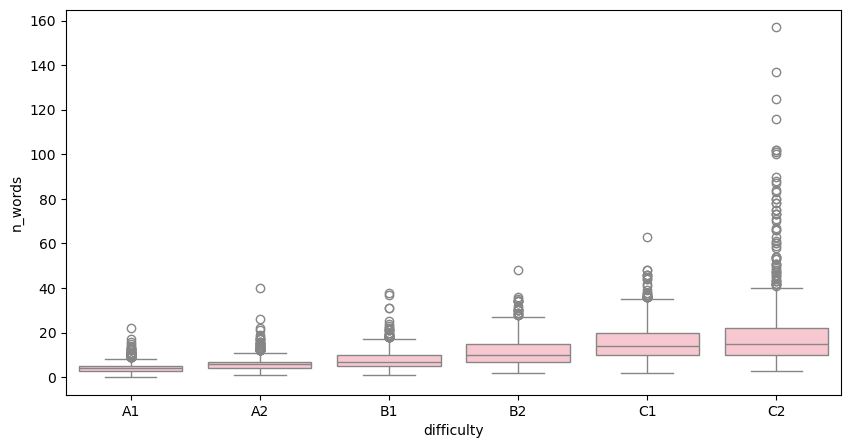

In [5]:
def add_n_words(df):
    df['n_words'] = df['tokens'].apply(len)
    return df

df = add_n_words(df)
inference = add_n_words(inference)

# let's visualize the correlation between the number of words and the difficulty
difficulty_order = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']  
plt.figure(figsize=(10, 5))
sns.boxplot(x='difficulty', y='n_words', data=df, color = color, order = difficulty_order)
plt.show()


There is a correlation between the number of words in a sentence and the difficulty of the sentence, so this feature could be useful.


### 3.2 Average word length
Calculated after removing stopwords.

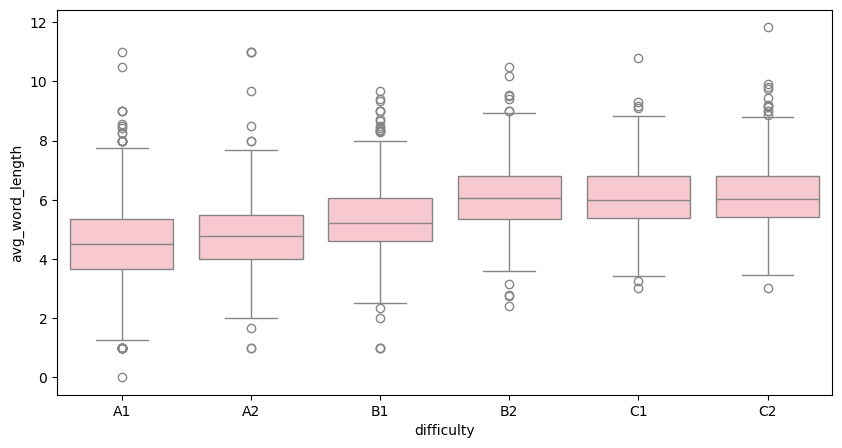

In [6]:


def add_avg_word_length_no_stopwords(df):
    df['avg_word_length'] = df['tokens'].apply(lambda tokens: np.mean([len(token.text) for token in tokens]) if tokens else 0)
    return df

df = add_avg_word_length_no_stopwords(df)
inference = add_avg_word_length_no_stopwords(inference)

# let's visualize the correlation between the average word length and the difficulty
plt.figure(figsize=(10, 5))
sns.boxplot(x='difficulty', y='avg_word_length', data=df, color = color, order = difficulty_order)
plt.show()


There is a correlation between the average word lenght and the difficulty, so we will keep this feature.

### 3.3 Part-of-Speech (POS) tags
We analyze the sentences and extract the POS tags for each word (after removing stopwords). Tags represent the syntactic role of each word in the sentence. We calculate the frequency of each tag. 

However, we won't use all the tags, but only the most relevant ones, chosen as the first 10 tags with the highest frequency. 

Top POS tags: ['NOUN', 'PUNCT', 'VERB', 'ADJ', 'PROPN']


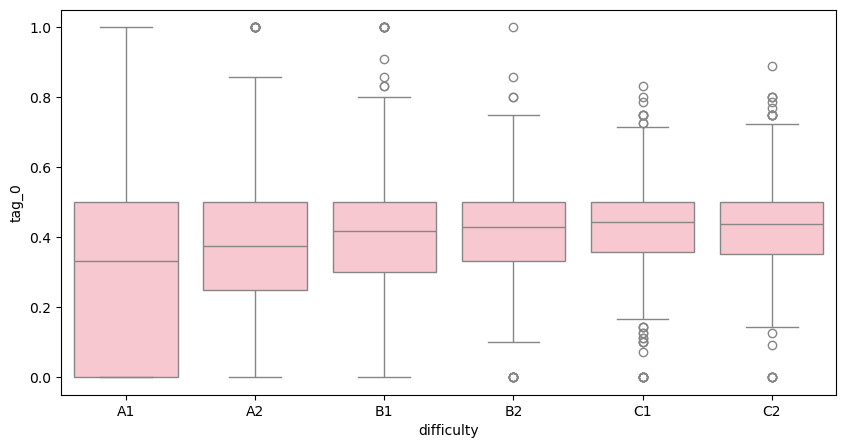

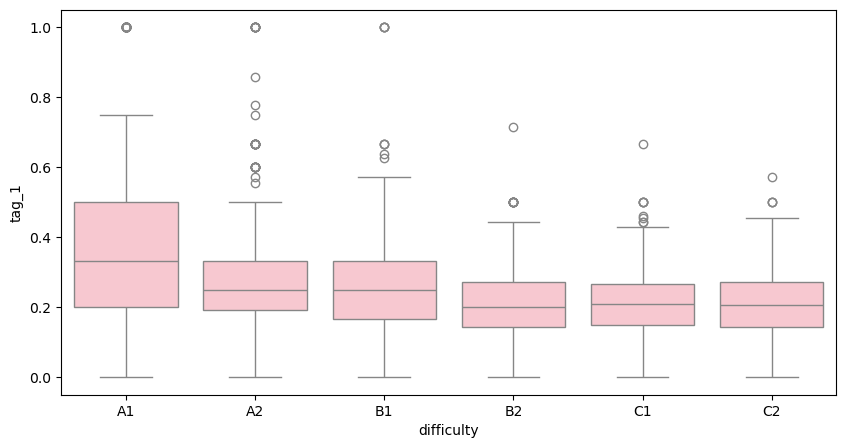

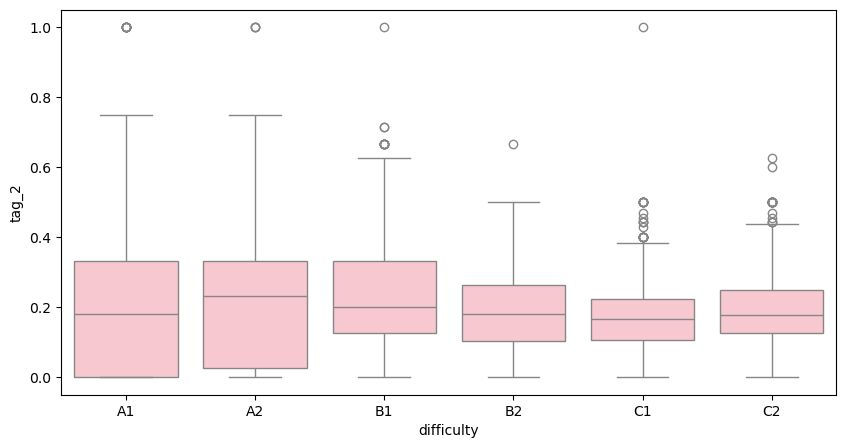

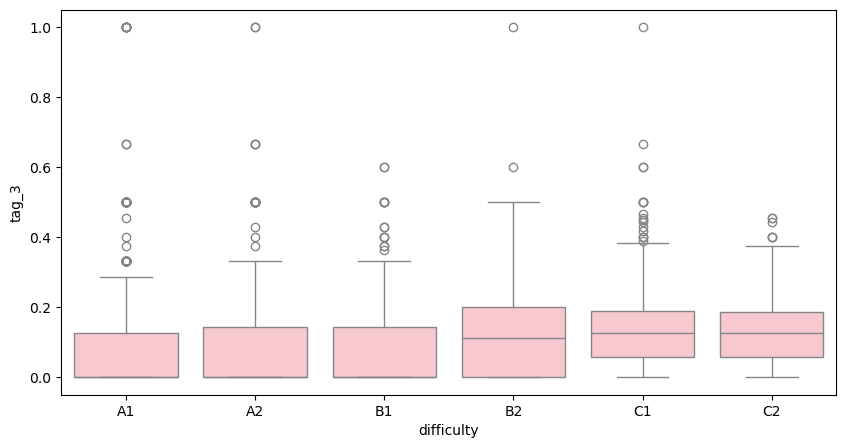

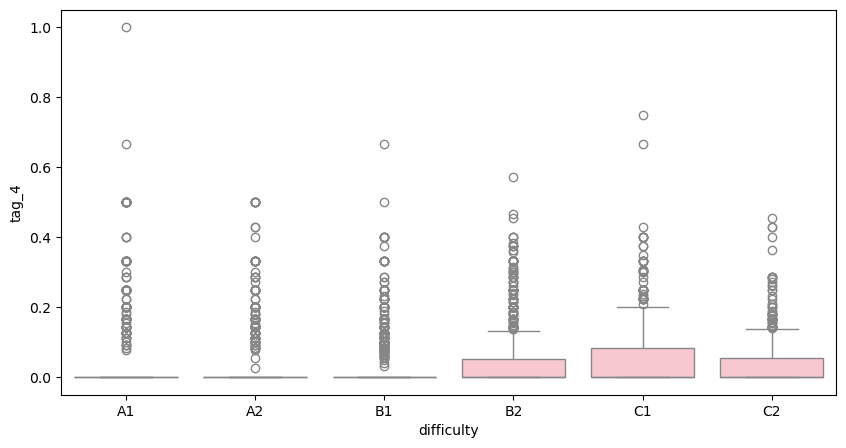

In [10]:
def calculate_pos_frequencies(pos_counts, top_tags):
    total = sum(pos_counts.get(tag, 0) for tag in top_tags)  # Use get for safe access
    return {tag: (pos_counts.get(tag, 0) / total if total > 0 else 0) for tag in top_tags}


all_tokens = pd.concat([df['tokens'], inference['tokens']], ignore_index=True)
total_tag_counts = defaultdict(int)  
for tokens in all_tokens:
    for token in tokens:
        if token.pos_ not in {'SPACE'}:  # Exclude punctuation and spaces
            total_tag_counts[token.pos_] += 1
top_tags = sorted(total_tag_counts.items(), key=lambda x: x[1], reverse=True)[:5]
top_tags = [tag for tag, _ in top_tags]
print("Top POS tags:", top_tags)


df['pos_frequencies'] = df['pos_counts'].apply(lambda x: calculate_pos_frequencies(x, top_tags))
inference['pos_frequencies'] = inference['pos_counts'].apply(lambda x: calculate_pos_frequencies(x, top_tags))

# Extracting frequencies for visualization or further analysis
for tag, i in zip(top_tags, range(len(top_tags))):
    df['tag_'+str(i)] = df['pos_frequencies'].apply(lambda x: x.get(tag, 0))
    inference[tag] = inference['pos_frequencies'].apply(lambda x: x.get(tag, 0))
# Let's visualize the correlation between the top POS tags and the difficulty
difficulty_order = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']  
for tag, i in zip(top_tags, range(len(top_tags))):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='difficulty', y='tag_'+str(i), data=df, order=difficulty_order, color = color)
    plt.show()

## 4. Processing of the sentences (generation of embeddings)
After adding the new features, we will process the sentences in order to be able to use them in the model and to improve the model's performance. In particular we want to create embeddings for the sentences using the CamemBERT/FlauBERT model.


We will:
- Apply tokenization using the CamemBERT/FlauBERT tokenizer;
- Pad the sequences to the same length;
- Create the attention masks;
- Create the embeddings for the sentences using the CamemBERT/FlauBERT model.

Since we are using CamemBERT and FlauBERT, we won't apply lemmatization or stemming, or remove stopwords, since these models are working with contextual words.



In [9]:
import torch

def get_tokenizer_model(chosen_tokenizer, num_classes):
    if chosen_tokenizer == 'camembert':
        tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
        model = CamembertModel.from_pretrained('camembert-base')
        classifier = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=num_classes)
    elif chosen_tokenizer == 'flaubert':
        tokenizer = FlaubertTokenizer.from_pretrained('flaubert/flaubert_base_cased')
        model = FlaubertModel.from_pretrained('flaubert/flaubert_base_cased')
        classifier = FlaubertForSequenceClassification.from_pretrained('flaubert/flaubert_base_cased', num_labels=num_classes)
    return tokenizer, model, classifier

chosen_tokenizer = 'camembert'
num_classes = df['difficulty'].nunique()
tokenizer, model, classifier = get_tokenizer_model(chosen_tokenizer, num_classes)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.2 Creating the embeddings
To apply the tokenizer, the padding and the attention masks we create a class CEFRDataset that will be used to process the training and test datasets and to convert the sentences into embeddings.

In [10]:
def get_embeddings(text):
    # Tokenize the text, with padding and truncation
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    encoded_input = {key: tensor.to(device) for key, tensor in encoded_input.items()}
    # Ensure we include the attention mask in the model input
    with torch.no_grad():
        output = model(**encoded_input)  # Simplified calling of model
    embeddings = output.last_hidden_state[:, 0, :].squeeze()

    # Extract the embeddings of the [CLS] token, which is at index 0
    return embeddings.cpu().numpy()

# Apply to your sentences
# since it could be quite long we apply it to batches (to use parallel processing)
def batched_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in tqdm.tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
        encoded_input = {key: tensor.to(device) for key, tensor in encoded_input.items()}
        with torch.no_grad():
            output = model(**encoded_input)
        embeddings = output.last_hidden_state[:, 0, :].detach().cpu().numpy()
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

# Assuming df['sentence'] is a list of texts
embeddings = batched_embeddings(df['sentence'].tolist())
df['embeddings'] = embeddings.tolist()

# Apply to the test dataset
inference_embeddings = batched_embeddings(inference['sentence'].tolist())
inference['embeddings'] = inference_embeddings.tolist()

100%|██████████| 38/38 [00:21<00:00,  1.78it/s]


In [11]:
# we have a look at the df right now:
df.head()

,id,sentence,difficulty,tokens,pos_counts,n_words,avg_word_length,pos_frequencies,NOUN,PUNCT,VERB,ADJ,PROPN,embeddings
0,0,Les coûts kilométriques réels peuvent diverger...,C1,"[coûts, kilométriques, réels, diverger, sensib...","{'NOUN': 14, 'ADJ': 3, 'VERB': 3, 'ADV': 2, 'P...",27,6.444444,"{'NOUN': 0.56, 'PUNCT': 0.2, 'VERB': 0.12, 'AD...",0.560000,0.200000,0.120000,0.120000,0.000000,"[0.07098422944545746, 0.09660283476114273, 0.0..."
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,"[bleu, ,, couleur, préférée, aime, vert, !]","{'NOUN': 2, 'PUNCT': 2, 'VERB': 2, 'PROPN': 1}",7,4.142857,"{'NOUN': 0.2857142857142857, 'PUNCT': 0.285714...",0.285714,0.285714,0.285714,0.000000,0.142857,"[-0.05412760749459267, -0.06828022003173828, 0..."
2,2,Le test de niveau en français est sur le site ...,A1,"[test, niveau, français, site, Internet, école...","{'NOUN': 6, 'PUNCT': 1}",7,5.142857,"{'NOUN': 0.8571428571428571, 'PUNCT': 0.142857...",0.857143,0.142857,0.000000,0.000000,0.000000,"[0.012144934386014938, 0.03654233366250992, 0...."
3,3,Est-ce que ton mari est aussi de Boston?,A1,"[-ce, mari, Boston, ?]","{'PRON': 1, 'NOUN': 1, 'PROPN': 1, 'PUNCT': 1}",4,3.500000,"{'NOUN': 0.3333333333333333, 'PUNCT': 0.333333...",0.333333,0.333333,0.000000,0.000000,0.333333,"[-0.004021527245640755, 0.02219346910715103, 0..."
4,4,"Dans les écoles de commerce, dans les couloirs...",B1,"[écoles, commerce, ,, couloirs, places, financ...","{'NOUN': 10, 'PUNCT': 5, 'ADJ': 2, 'VERB': 4, ...",24,5.375000,"{'NOUN': 0.47619047619047616, 'PUNCT': 0.23809...",0.476190,0.238095,0.190476,0.095238,0.000000,"[0.02371220290660858, -0.02964732050895691, 0...."


In [12]:
inference.head()

,id,sentence,tokens,pos_counts,n_words,avg_word_length,pos_frequencies,NOUN,PUNCT,VERB,ADJ,PROPN,embeddings
0,0,Nous dûmes nous excuser des propos que nous eû...,"[dûmes, excuser, propos, eûmes, prononcés]","{'ADJ': 1, 'VERB': 3, 'NOUN': 1}",5,6.400000,"{'NOUN': 0.2, 'PUNCT': 0.0, 'VERB': 0.6, 'ADJ'...",0.200000,0.000000,0.600000,0.200000,0.000000,"[0.04623586684465408, 0.13113509118556976, 0.1..."
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...,"[pouvez, savoir, plaisir, recevoir, bonne, nou...","{'VERB': 3, 'NOUN': 1, 'ADJ': 2, 'PUNCT': 1}",7,5.857143,"{'NOUN': 0.14285714285714285, 'PUNCT': 0.14285...",0.142857,0.142857,0.428571,0.285714,0.000000,"[-0.06660883873701096, -0.014503978192806244, ..."
2,2,"Et, paradoxalement, boire froid n'est pas la b...","[,, paradoxalement, ,, boire, froid, bonne, pa...","{'PUNCT': 3, 'ADV': 1, 'VERB': 1, 'ADJ': 2, 'N...",8,4.750000,"{'NOUN': 0.14285714285714285, 'PUNCT': 0.42857...",0.142857,0.428571,0.142857,0.285714,0.000000,"[0.0031737228855490685, 0.03613223135471344, 0..."
3,3,"Ce n'est pas étonnant, car c'est une saison my...","[étonnant, ,, saison, mystérieuse]","{'ADJ': 2, 'PUNCT': 1, 'NOUN': 1}",4,6.500000,"{'NOUN': 0.25, 'PUNCT': 0.25, 'VERB': 0.0, 'AD...",0.250000,0.250000,0.000000,0.500000,0.000000,"[-0.024849681183695793, 0.0032904967665672302,..."
4,4,"Le corps de Golo lui-même, d'une essence aussi...","[corps, Golo, ,, essence, surnaturelle, montur...","{'NOUN': 13, 'PROPN': 1, 'PUNCT': 6, 'ADJ': 7,...",40,6.450000,"{'NOUN': 0.37142857142857144, 'PUNCT': 0.17142...",0.371429,0.171429,0.228571,0.200000,0.028571,"[0.046980034559965134, 0.11302952468395233, -0..."


# 5. Preprocessing of the target variable
## Label encoding of the target variable
The target variable contains the difficulty levels as strings (A1, A2, B1, B2, C1, C2). We convert these strings to integers using the LabelEncoder from the scikit-learn library.

In [13]:
y = df['difficulty'].values

# Define the order of your labels
labels_ordered = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Manually fit the encoder to the ordered labels
encoder.fit(labels_ordered)

# Encode your actual labels
y_encoded = encoder.transform(y)

# Output the encoding to verify
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label mapping:", label_mapping)      
print(y, y_encoded)

Label mapping: {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
['C1' 'A1' 'A1' ... 'A2' 'C2' 'C2'] [4 0 0 ... 1 5 5]


### 5.2 Tensor datasets

In [62]:
feature_columns

['n_words', 'avg_word_length', 'NOUN', 'PUNCT', 'VERB', 'ADJ', 'PROPN']

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

embeddings_array = np.vstack(df['embeddings'].values)
excluded_columns_training = ['id', 'sentence', 'difficulty', 'embeddings', 'tokens', 'pos_counts', 'pos_frequencies']
feature_columns = [col for col in df.columns if col not in excluded_columns_training]
additional_features = df[feature_columns].values
#we apply a scaler to the additional features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
additional_features = scaler.fit_transform(additional_features)

# Define the model
# Combine embeddings and other features
X = np.hstack((embeddings_array, additional_features))

# Target variable (already encoded)
y = y_encoded
###

excluded_columns_inference= ['id', 'sentence', 'embeddings', 'tokens', 'pos_counts', 'pos_frequencies']
inference_embeddings_array = np.vstack(inference['embeddings'].values)
inference_feature_columns = [col for col in inference.columns if col not in excluded_columns_inference]
inference_additional_features = inference[inference_feature_columns].values
# Apply the same scaler to the additional features
inference_additional_features = scaler.transform(inference_additional_features)
# Combine embeddings and other features
X_inference = np.hstack((inference_embeddings_array, inference_additional_features))

# turn into tensors
embedding_dim = embeddings_array.shape[1]  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Combine embeddings and other features for inference
inference_tensors = torch.tensor(X_inference, dtype=torch.float32)

# we create a dataloader that will be used in the pretrained classifier
training_dataloader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=True)
inference_dataloader = DataLoader(TensorDataset(inference_tensors), batch_size=32, shuffle=False)

## for the moment we don't split the data into training and validation

## 6. Model architecture

### 6.1 Neural network architecture
We will use a neural network that can use, as input, the embeddings of the sentences and the additional features. 

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentenceDifficultyPredictor(nn.Module):
    def __init__(self, embedding_dim, num_features, hidden_dim, output_dim, num_hidden_layers=2, use_features=True, activation_function='relu', init_mode='default', dropout_rate=0.5):
        super(SentenceDifficultyPredictor, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.use_features = use_features
        self.num_hidden_layers = num_hidden_layers
        self.activation_function = activation_function
        self.dropout = nn.Dropout(dropout_rate)
        
        # Embedding layer for the embeddings part of the input
        self.embedding_fc = nn.Linear(embedding_dim, hidden_dim)
        
        # Additional features layer for the features part of the input, used conditionally
        if self.use_features:
            self.features_fc = nn.Linear(num_features, hidden_dim)
            input_dim = hidden_dim * 2  # Combined embedding and feature dimensions
        else:
            input_dim = hidden_dim  # Only embedding dimension
        
        # Creating a list of hidden layers
        self.hidden_layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim)] + 
                                           [nn.Linear(hidden_dim, hidden_dim) for _ in range(1, num_hidden_layers)])
        
        # Batch Normalization layers after each hidden layer
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(num_hidden_layers + 1)])
        
        # Output layer
        self.output_fc = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights
        self._init_weights(init_mode)

    def _init_weights(self, mode):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if mode == 'xavier':
                    nn.init.xavier_uniform_(module.weight)
                elif mode == 'kaiming':
                    nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
                else:
                    nn.init.normal_(module.weight, mean=0, std=0.01)

    def forward(self, x):
        # Split the input tensor into embeddings and optionally features
        embeddings = x[:, :self.embedding_dim]
        if self.use_features:
            features = x[:, self.embedding_dim:]

        # Apply activation function dynamically
        def apply_activation(x):
            if self.activation_function == 'relu':
                return F.relu(x)
            elif self.activation_function == 'tanh':
                return torch.tanh(x)
            elif self.activation_function == 'sigmoid':
                return torch.sigmoid(x)
            else:
                return F.leaky_relu(x, 0.01)  # default to leaky_relu if not specified

        # Process embeddings through its layer
        embedded = self.dropout(apply_activation(self.embedding_fc(embeddings)))
        
        if self.use_features:
            features_output = self.dropout(apply_activation(self.features_fc(features)))
            combined = torch.cat((embedded, features_output), dim=1)
        else:
            combined = embedded  # Use embeddings alone if features are not used

        # Apply hidden layers with Batch Normalization and Dropout
        for i, layer in enumerate(self.hidden_layers):
            combined = apply_activation(layer(combined))
            combined = self.batch_norms[i](combined)
            combined = self.dropout(combined)

        output = self.output_fc(combined)
        return output


### 6.2 Language model (CamemBERT/FlauBERT)
We set up a second model, based on the CamemBERT/FlauBERT classifier and with the possibility of also using the additional features that were defined in the data augmentation step.

To do so we create a network that accepts both the classifier and the additional features as additional dense layers.

The first step consists in pre-training the CamemBERT/FlauBERT model on the training data. We will use the embeddings generated in the previous step as input to the model.

In [17]:
#We first do a fine-tuning of the classifier. 
# since we don't have a lot of data we will unfreeze only the top layers of the model.
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torch

class SentenceDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = str(self.sentences[idx])
        label = self.labels[idx]

        # Encoding the sentences using the tokenizer provided
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=self.max_len,  # Pad & truncate all sentences.
            truncation=True,
            padding='max_length',  # Pad sentences to max length
            return_attention_mask=True,  # Return attention mask
            return_tensors='pt',  # Return PyTorch tensors
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = classifier.to(device)  # Your pre-trained classifier

# Prepare optimizer
param_optimizer = list(classifier.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
num_epochs = 2

sentences = df['sentence'].tolist()
labels = y_encoded  
max_len = 512
train_dataset = SentenceDataset(sentences=sentences, labels=labels, tokenizer=tokenizer, max_len=max_len)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
finetune = False
if finetune:
# Training loop
    classifier.train()
    for epoch in range(num_epochs): #for now we are directly training on the training data, then we will split it into training and validation and only later we will use the test data
        train_iterator = tqdm.tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for step, batch in train_iterator:
            # Access the batch data correctly:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            
            # Forward pass through the model
            outputs = classifier(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss  # Assuming that the model's forward returns a dictionary with 'loss'

            # Backward and optimize
            loss.backward()
            optimizer.step()

In [59]:
import torch
import torch.nn as nn
from transformers import CamembertModel, FlaubertModel, CamembertTokenizer, FlaubertTokenizer

import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedClassifier(nn.Module):
    def __init__(self, classifier, num_features, use_features=False, hidden_dim=128, output_dim=None):
        super(CombinedClassifier, self).__init__()
        self.classifier = classifier
        self.use_features = use_features
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        if output_dim is None:
            self.output_dim = 6  # example, adjust based on actual number of classes or output needs
        else:
            self.output_dim = output_dim

        if use_features:
            self.features_fc = nn.Linear(num_features, hidden_dim)
        # Adjust this to match your classifier's output dimensions + any additional features
        self.output_fc = nn.Linear(hidden_dim if use_features else 1, self.output_dim)

    def forward(self, X, attention_mask=None):
        #print("Forward pass initiated.")
        #print(f"Input shape: {X.shape}")

        input_ids = X[:, :-self.num_features].long()
        features = X[:, -self.num_features:] if self.use_features else None

        #print(f"Input IDs shape: {input_ids.shape}")
        #if self.use_features:
            #print(f"Features shape: {features.shape}")

        outputs = self.classifier(input_ids=input_ids, attention_mask=attention_mask)
        classifier_output = outputs[0][:, 0]  # Assuming this output is already in a processed form

        classifier_output = classifier_output.unsqueeze(1)  # Ensure it has a second dimension
        #print(f"Classifier output shape (after unsqueeze): {classifier_output.shape}")

        if self.use_features:
            features_output = F.relu(self.features_fc(features))
            combined_output = torch.cat((classifier_output, features_output), dim=1)
            #print(f"Combined output shape (after concatenation): {combined_output.shape}")
        else:
            combined_output = classifier_output

        output = self.output_fc(combined_output)
        #print(f"Final output shape (after output_fc): {output.shape}")
        return output




## 7. Training the model


## Hyperparameter tuning with random search


In [29]:
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
import numpy as np
import torch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from sklearn.model_selection import train_test_split
from torch.optim import SGD
import torch
from torch.optim import SGD
from skorch import NeuralNetClassifier
from sklearn.model_selection import RandomizedSearchCV
import torch
from torch.optim import Adam, SGD
from sklearn.model_selection import train_test_split



num_features = additional_features.shape[1]
# Assuming X_embeddings, X_features, and y_labels are your preprocessed data tensors
X_combined = X_tensor.numpy()
y_combined = y_tensor.numpy()

# Split the data for validation during training
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)


# Initialize the Skorch neural network classifier
net_nn = NeuralNetClassifier(
    module=SentenceDifficultyPredictor,
    module__embedding_dim=embedding_dim,
    module__num_features=num_features,
    module__hidden_dim=128,     # Default hidden dimension
    module__output_dim=6,       # Default number of output classes; adjust as necessary
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=SGD,
    optimizer__lr=0.01,
    max_epochs=20,
    batch_size=64,
    iterator_train__shuffle=True,
    train_split=None,  # No predefined split since we are using RandomizedSearchCV
    verbose=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if available
)


# Hyperparameter space to explore
params_nn = {
    'lr': [0.01, 0.005, 0.001, 0.0005, 0.0001],
    'optimizer__momentum': [0.9, 0.95, 0.99],
    'module__num_hidden_layers': [1, 2, 3],
    'module__hidden_dim': [128, 256, 512],
    'module__activation_function': ['relu', 'tanh', 'sigmoid', 'leaky_relu'],
    'module__init_mode': ['default', 'xavier', 'kaiming'],
    'module__use_features': [True, False],
    'batch_size': [16, 32, 64],
    'max_epochs': [10, 20],
}



# Perform randomized search
rs_nn = RandomizedSearchCV(
    net_nn,
    params_nn,
    refit=True,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_iter=10,
    random_state=42
)



rs_nn.fit(X_combined, y_combined)  
print("Best parameters:", rs_nn.best_params_)
print("Best cross-validation score (accuracy):", rs_nn.best_score_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
  epoch    train_loss     dur
-------  ------------  ------
      1        2.3816  0.1700
      2        1.7656  0.1780
      3        1.6132  0.1591
      4        1.5640  0.1628
      5        1.5089  0.1806
      6        1.5117  0.1861
      7        1.4603  0.1803
      8        1.4279  0.1688
      9        1.4377  0.1688
     10        1.3905  0.1693
[CV] END batch_size=64, lr=0.001, max_epochs=10, module__activation_function=tanh, module__hidden_dim=256, module__init_mode=xavier, module__num_hidden_layers=2, module__use_features=False, optimizer__momentum=0.9; total time=   1.8s
  epoch    train_loss     dur
-------  ------------  ------
      1        2.4137  0.1691
      2        1.7568  0.1695
      3        1.5898  0.1602
      4        1.5411  0.1614
      5        1.5177  0.1613
      6        1.4776  0.1671
      7        1.4600  0.1736
      8        1.4266  0.1872
      9        1.4161  0.1659
     10        

In [ ]:
num_classes

In [61]:
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
import numpy as np
import torch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from sklearn.model_selection import train_test_split
from torch.optim import SGD
import torch
from torch.optim import SGD
from skorch import NeuralNetClassifier
from sklearn.model_selection import RandomizedSearchCV
import torch
from torch.optim import Adam, SGD
from sklearn.model_selection import train_test_split
from scipy.stats import uniform


num_features = additional_features.shape[1]
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, features, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'X': torch.cat((self.input_ids[idx], self.features[idx]), dim=0),  # Assuming dimension 0 is correct
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx],
            'input_ids': self.input_ids[idx],
            'features': self.features[idx]
        }

# Create dataset
additional_features_tensor = torch.tensor(additional_features, dtype=torch.float32)
encoded_input = tokenizer(df['sentence'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
input_ids = encoded_input['input_ids'].clone().detach()
attention_mask = encoded_input['attention_mask'].clone().detach()
labels = torch.tensor(y_encoded, dtype=torch.long)
dataset = CustomDataset(input_ids, attention_mask, additional_features_tensor, labels)


test_dataset = CustomDataset(input_ids, attention_mask, additional_features_tensor, labels)
test_loader = DataLoader(test_dataset, batch_size=1)

for data in test_loader:
    print(data['X'].shape)  # Check the shape
    print(data['attention_mask'].shape)  # Check the shape
    print(data['labels'].shape)  # Check the shape
    break  # Just one batch for testing

# Split the data for training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
#X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Create DataLoader
# Define a custom initialization function for the CombinedClassifier with pre-loaded classifier
def init_combined_classifier(classifier, num_features, **kwargs):
    return CombinedClassifier(classifier=classifier, num_features=num_features, **kwargs)


# Load the pre-trained model (assuming it's already configured and loaded)
pretrained_classifier = classifier  # This should be your pre-trained Camembert or Flaubert model

# Initialize the Skorch neural network classifier for CombinedClassifier
# Initialize your Skorch wrapper
net_bert = NeuralNetClassifier(
    module=CombinedClassifier(pretrained_classifier, num_features, use_features=True, hidden_dim=128, output_dim=num_classes),
    module__classifier=pretrained_classifier,
    module__num_features=num_features,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer__lr=0.01,
    max_epochs=20,
    batch_size=64,
    iterator_train__shuffle=True,
    train_split=None,
    verbose=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Adjust hyperparameters for both the pre-trained model layers and new layers
params_bert = {
    'optimizer__lr': [0.001],  # Learning rates between 0.005 and 0.015
    'max_epochs': [10],  # Different epochs to try
    'batch_size': [16],  # Different batch sizes to try
    'module__hidden_dim': [128],  # Hidden dimensions if your model uses this parameter
}
# Perform randomized search
rs_bert = RandomizedSearchCV(
    net_bert,
    params_bert,
    n_iter=10,  # Number of parameter settings sampled
    scoring='accuracy',  # or any other appropriate scorer function
    cv=3,  # 3-fold cross-validation
    random_state=42,
    verbose=2
)
def extract_dataset(dataset):
    # Assumes dataset is a torch.utils.data.Subset
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    
    for batch in loader:
        print(batch.keys())
        return batch['input_ids'], batch['features'], batch['labels']
    
# Extract the train and validation datasets
X_train, features_train, y_train = extract_dataset(train_dataset)
X_val, features_val, y_val = extract_dataset(val_dataset)

# Combine the extracted data for input to Skorch
X_combined_train = torch.cat((X_train, features_train), dim=1)
X_combined_val = torch.cat((X_val, features_val), dim=1)

rs_bert.fit(X_combined_train, y_train)  # Fit the model using the training set

print("Best parameters:", rs_bert.best_params_)
print("Best cross-validation score (accuracy):", rs_bert.best_score_)

torch.Size([1, 135])
torch.Size([1, 128])
torch.Size([1])
dict_keys(['X', 'attention_mask', 'labels', 'input_ids', 'features'])
dict_keys(['X', 'attention_mask', 'labels', 'input_ids', 'features'])


/Users/vaienti/miniforge3/envs/cartogenealogy/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
  epoch    train_loss       dur
-------  ------------  --------
      1        1.9338  232.5410
      2        1.9192  231.6305
      3        1.8927  232.1692
      4        1.8731  230.1863
      5        1.8686  231.3753
      6        1.8452  1754.1725
      7        1.8170  232.9709
      8        1.8022  229.9252
      9        1.7830  230.1004
     10        1.7695  244.0328
[CV] END batch_size=16, max_epochs=10, module__hidden_dim=128, optimizer__lr=0.001; total time=64.7min
  epoch    train_loss       dur
-------  ------------  --------
      1        1.8698  236.7829
      2        1.8633  257.1675
      3        1.8506  258.7413
      4        1.8360  42439.9904
      5        1.8241  266.6101
      6        1.8122  253.1744
      7        1.8000  259.5830
      8        1.7984  266.2798
      9        1.8094  253.6321
     10        1.7892  251.6102
[CV] END batch_size=16, max_epochs=10, module__hidden_dim=128, opti

  param_lr param_optimizer__momentum param_module__hidden_dim  \
0    0.001                       0.9                      256   
1     0.01                      0.99                      128   
2   0.0001                      0.99                      128   
3   0.0001                       0.9                      512   
4   0.0005                      0.95                      256   
5   0.0001                      0.95                      512   
6   0.0005                      0.99                      128   
7   0.0005                      0.95                      128   
8    0.005                      0.99                      128   
9   0.0005                      0.99                      128   

  param_module__activation_function param_batch_size  mean_test_score  \
0                              tanh               64         0.495573   
1                              tanh               16         0.167448   
2                              tanh               16         0.24

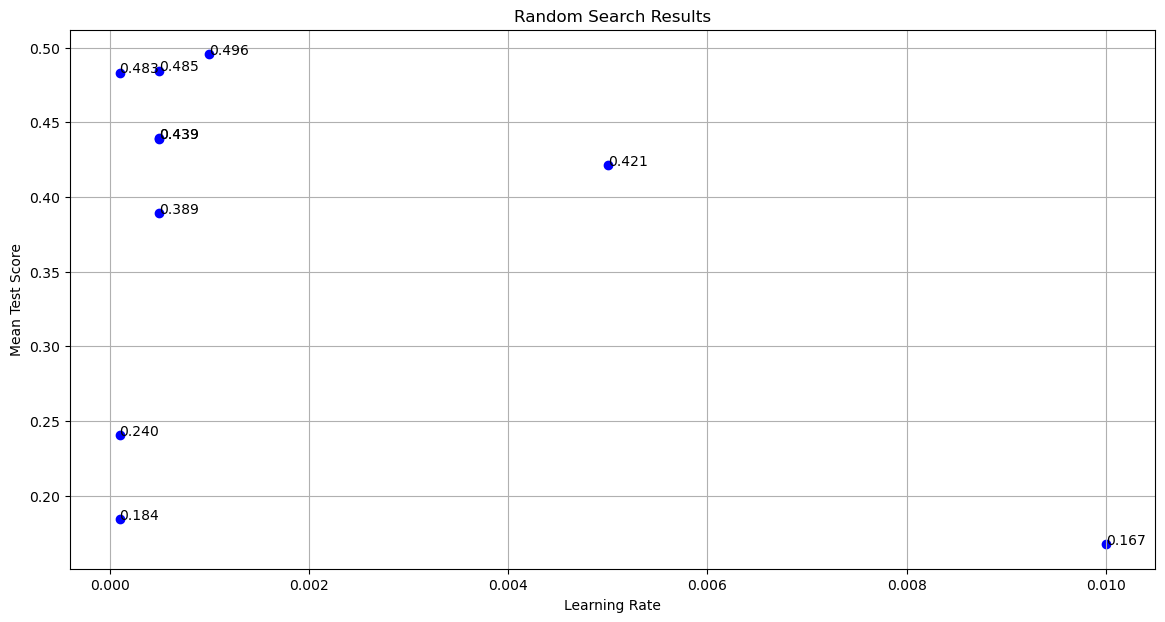

              precision    recall  f1-score   support

          A1       0.49      0.93      0.64       166
          A2       0.47      0.22      0.29       158
          B1       0.42      0.41      0.42       166
          B2       0.41      0.61      0.49       153
          C1       0.56      0.24      0.34       152
          C2       0.63      0.45      0.53       165

    accuracy                           0.48       960
   macro avg       0.50      0.48      0.45       960
weighted avg       0.50      0.48      0.45       960



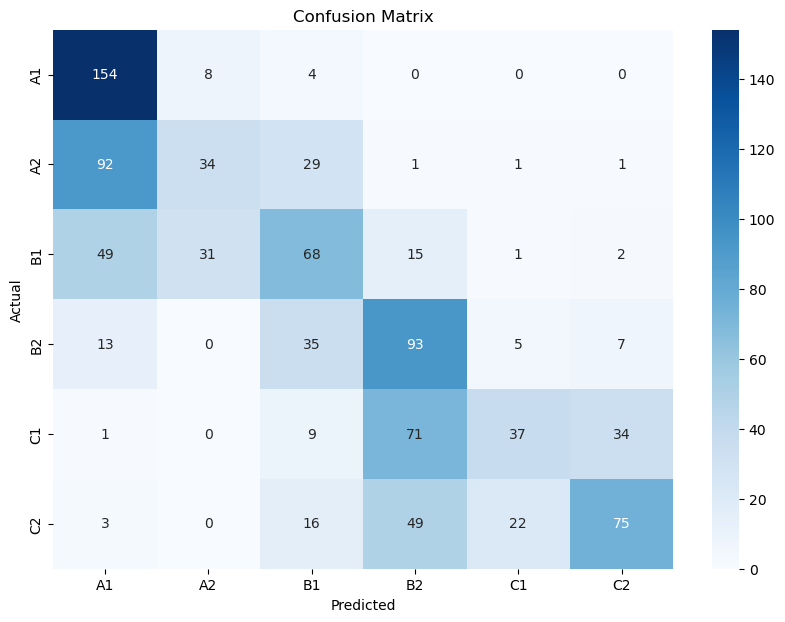

Accuracy: 0.48020833333333335


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'rs' is your RandomizedSearchCV object after fitting
results = pd.DataFrame(rs.cv_results_)
print(results[['param_lr', 'param_optimizer__momentum', 'param_module__hidden_dim', 'param_module__activation_function', 'param_batch_size', 'mean_test_score', 'std_test_score']])

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# You can customize this part to plot different hyperparameters
# Here, we plot learning rate against the mean test score
ax.scatter(results['param_lr'], results['mean_test_score'], color='blue')
for i, txt in enumerate(results['mean_test_score']):
    ax.annotate(f"{txt:.3f}", (results['param_lr'][i], results['mean_test_score'][i]))

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean Test Score')
ax.set_title('Random Search Results')
ax.grid(True)

plt.show()

# plot the accuracy for each class
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'rs' is your RandomizedSearchCV object after fitting
y_pred = rs.predict(X_val)

# Decode the predictions
y_pred_decoded = encoder.inverse_transform(y_pred)
y_val_decoded = encoder.inverse_transform(y_val)

# Print the classification report
print(classification_report(y_val_decoded, y_pred_decoded))
#plot the confusion matrix
cm = confusion_matrix(y_val_decoded, y_pred_decoded, labels=labels_ordered)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_ordered, yticklabels=labels_ordered, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Calculate the accuracy
accuracy = accuracy_score(y_val_decoded, y_pred_decoded)
print("Accuracy:", accuracy)

# You can also create similar plots for other parameters by copying the plotting block and adjusting the x-axis parameter.


In [21]:
from skorch import NeuralNetClassifier
from torch.optim import SGD
import torch

# Assuming 'SentenceDifficultyPredictor' and 'rs' (RandomizedSearchCV object) are defined and imported correctly

# Extract best parameters
best_params = rs.best_params_
print("Best parameters found:", best_params)

# Parameters
embedding_dim = embeddings_array.shape[1]  # Ensure embeddings_array is defined and correct
num_features = additional_features.shape[1]  # Ensure additional_features is defined and correct
output_dim = 6  # Adjust based on your number of classes

# Setup the model with the best parameters
net = NeuralNetClassifier(
    module=SentenceDifficultyPredictor,
    module__embedding_dim=embedding_dim,
    module__num_features=num_features,
    module__hidden_dim=best_params['module__hidden_dim'],
    module__output_dim=output_dim,
    criterion=torch.nn.CrossEntropyLoss(),  # Instantiate the loss function
    optimizer=SGD,
    optimizer__lr=best_params['lr'],
    optimizer__momentum=best_params['optimizer__momentum'],
    max_epochs=50,  # Adjust epochs if necessary
    batch_size=best_params['batch_size'],
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Automatically use GPU if available
    iterator_train__shuffle=True,
    verbose=1
)

# Train the model on the full dataset
net.fit(X_tensor, y_tensor)  # Ensure X_tensor and y_tensor are defined and prepared

# Optionally evaluate the model if you have a separate test set
# Example:
# test_score = net.score(X_test, y_test)
# print("Test score:", test_score)

# Predict on the inference dataset
# Ensure inference_tensors is prepared and correctly formatted as expected by the model
predictions = net.predict(inference_tensors)  # Assuming inference_tensors is prepared

# You could print or further process the predictions here
print("Predictions:", predictions)


Best parameters found: {'optimizer__momentum': 0.9, 'module__use_features': False, 'module__num_hidden_layers': 2, 'module__init_mode': 'xavier', 'module__hidden_dim': 256, 'module__activation_function': 'tanh', 'max_epochs': 10, 'lr': 0.001, 'batch_size': 64}
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7924       0.1677        1.7923  0.1368
      2        1.7923       0.1677        1.7921  0.1352
      3        1.7922       0.1677        1.7921  0.1351
      4        1.7921       0.1677        1.7920  0.1225
      5        1.7920       0.1677        1.7919  0.1251
      6        1.7920       0.1677        1.7919  0.1249
      7        1.7919       0.1698        1.7918  0.1241
      8        1.7919       0.1698        1.7918  0.1455
      9        1.7919       0.1698        1.7918  0.1234
     10        1.7918       0.1698        1.7918  0.1191
     11        1.7918       0.1698        1.7917  0.139

In [22]:
predictions = net.predict(inference_tensors)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder


# Decode the predictions
predictions_decoded = encoder.inverse_transform(predictions)

# Assuming 'inference' is your DataFrame containing test data
inference['difficulty'] = predictions_decoded

# Only keep the columns 'id' and 'difficulty'
inference_to_save = inference[['id', 'difficulty']]

# Save to CSV
inference_to_save.to_csv('../kaggle_submissions/predictions_with_augmentation.csv', index=False)

print("Predictions saved to CSV successfully.")


Predictions saved to CSV successfully.


### 7.1 (optional) 20% validation split
We split the training data into training and validation data (80% training, 20% validation), just to see how the model is performing without any hyperparameter tuning.

In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from sklearn.model_selection import train_test_split
import torch.optim as optim

# Example: Assume embeddings and features have already been combined into X_tensor
# and the labels are in y_tensor, also make sure the tensors are of correct types
# X_tensor = torch.cat((embeddings_tensor, features_tensor), dim=1).float()
# y_tensor = labels_tensor.long()

# Split the dataset into training and testing
train_size = 0.8
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, train_size=train_size, random_state=42)

# Create DataLoader for train and test sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model initialization
embedding_dim = X_train.size(1) - num_features  # Assuming num_features is known
num_classes = len(torch.unique(y_tensor))  # Assuming y_tensor contains all labels
model = SentenceDifficultyPredictor(embedding_dim, num_features, 32, num_classes)

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=60):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

# Testing function
def test_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in test_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == y_batch).sum().item()
    accuracy = 100 * correct_predictions / len(test_loader.dataset)
    print(f"Test Loss: {total_loss / len(test_loader)}, Accuracy: {accuracy}%")

# Call training and testing functions
train_model(model, train_loader, criterion, optimizer, num_epochs=100)
test_model(model, test_loader, criterion)


Epoch 1, Loss: 1.7880193531513213
Epoch 2, Loss: 1.5800122638543448
Epoch 3, Loss: 1.317736287911733
Epoch 4, Loss: 1.2411859532197316
Epoch 5, Loss: 1.2177794416745504
Epoch 6, Loss: 1.2088148256142934
Epoch 7, Loss: 1.1925278067588807
Epoch 8, Loss: 1.1787460704644521
Epoch 9, Loss: 1.1722205956776937
Epoch 10, Loss: 1.1636190245548883
Epoch 11, Loss: 1.157827522357305
Epoch 12, Loss: 1.1474411209424338
Epoch 13, Loss: 1.145652891198794
Epoch 14, Loss: 1.1454096794128419
Epoch 15, Loss: 1.1368441869815191
Epoch 16, Loss: 1.1289864559968312
Epoch 17, Loss: 1.1310199479262033
Epoch 18, Loss: 1.1168127963940302
Epoch 19, Loss: 1.1144968390464782
Epoch 20, Loss: 1.1067263553539912
Epoch 21, Loss: 1.1075605511665345
Epoch 22, Loss: 1.1054451723893484
Epoch 23, Loss: 1.0950074603160223
Epoch 24, Loss: 1.0918155550956725
Epoch 25, Loss: 1.0922789911429087
Epoch 26, Loss: 1.0943271478017171
Epoch 27, Loss: 1.0815381407737732
Epoch 28, Loss: 1.0754841685295105
Epoch 29, Loss: 1.07902084887027